In [3]:
import xarray as xr
import pandas as pd
import geopandas as gpd
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from datetime import datetime
import rasterio as rio

import planetary_computer
import pystac_client
import odc.stac

In [4]:
#SERIES DE TIEMPO

In [11]:
bbox_of_interest = [-60.00, -36.84, -58.00, -34.50]            #often is the MIN X value, MIN Y value, MAX X value, MAX Y value
time_of_interest = "2022-03-01/2023-03-15"                     #SPECIFIED BY STRINGS

In [12]:
%%time

# if you have an account (https://planetarycomputer.developer.azure-api.net/profile)
#os.environ['PC_SDK_SUBSCRIPTION_KEY'] = 'fgh1cc0c158a493f9bce23564c667856'  
# Always set this when reading from URLs
os.environ['GDAL_DISABLE_READDIR_ON_OPEN']='EMPTY_DIR'

catalog = pystac_client.Client.open(                                             #search for all data hosted in planetary_computer
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

search = catalog.search(
    collections=["landsat-c2-l2"],  #corrected at an atmosferic correction...we are looking at the surface rather the top of the atmosphere.
    bbox=bbox_of_interest,
    datetime=time_of_interest,
    query={"eo:cloud_cover": {"lt": 10}},
)

items = search.get_all_items()
print(f"Returned {len(items)} Items")

Returned 169 Items
CPU times: user 216 ms, sys: 3.4 ms, total: 220 ms
Wall time: 833 ms


In [7]:
items

ID: LE07_L2SP_225084_20220823_02_T1
"Bounding Box: [-60.60579543, -35.59398513, -57.90841828, -33.65323487]"
Datetime: 2022-08-23 12:11:55.375485+00:00
gsd: 30
created: 2022-09-21T09:25:54.808146Z
sci:doi: 10.5066/P9C7I13B
datetime: 2022-08-23T12:11:55.375485Z
platform: landsat-7
proj:epsg: 32621
"proj:shape: [7001, 8091]"
description: Landsat Collection 2 Level-2


In [13]:
# iTEMS IS A LIST OF gEOjon fEATURES, YOU CAN TURN IT INTO A gEOpANDAS TABLE FOR 
gf = gpd.GeoDataFrame.from_features(items.to_dict(), crs='EPSG:4326')
                                    
gf.head (3) 

,geometry,gsd,created,sci:doi,datetime,platform,proj:epsg,proj:shape,description,instruments,...,landsat:wrs_row,landsat:scene_id,landsat:wrs_path,landsat:wrs_type,view:sun_azimuth,landsat:correction,view:sun_elevation,landsat:cloud_cover_land,landsat:collection_number,landsat:collection_category
0,"POLYGON ((-60.34219 -36.41845, -60.87639 -38.1...",30,2023-03-10T05:37:05.136648Z,10.5066/P9OGBGM6,2023-02-27T13:45:29.416358Z,landsat-8,32621,"[7701, 7661]",Landsat Collection 2 Level-2,"[oli, tirs]",...,086,LC82250862023058LGN00,225,2,57.750324,L2SP,46.081425,0.06,02,T1
1,"POLYGON ((-59.91007 -34.98866, -60.42814 -36.6...",30,2023-03-10T05:37:04.143487Z,10.5066/P9OGBGM6,2023-02-27T13:45:05.466014Z,landsat-8,32621,"[7721, 7671]",Landsat Collection 2 Level-2,"[oli, tirs]",...,085,LC82250852023058LGN00,225,2,58.700844,L2SP,47.053563,0.05,02,T1
2,"POLYGON ((-59.48962 -33.55727, -59.99359 -35.2...",30,2023-03-15T05:41:10.809193Z,10.5066/P9OGBGM6,2023-02-27T13:44:41.511435Z,landsat-8,32621,"[7731, 7681]",Landsat Collection 2 Level-2,"[oli, tirs]",...,084,LC82250842023058LGN00,225,2,59.725547,L2SP,48.003942,1.42,02,T1


In [14]:
gf.iloc[0]

geometry                       POLYGON ((-60.3421919 -36.418453, -60.8763949 ...
gsd                                                                           30
created                                              2023-03-10T05:37:05.136648Z
sci:doi                                                         10.5066/P9OGBGM6
datetime                                             2023-02-27T13:45:29.416358Z
platform                                                               landsat-8
proj:epsg                                                                  32621
proj:shape                                                          [7701, 7661]
description                                         Landsat Collection 2 Level-2
instruments                                                          [oli, tirs]
eo:cloud_cover                                                              0.06
proj:transform                     [30.0, 0.0, 158985.0, 0.0, -30.0, -4035285.0]
view:off_nadir              

In [15]:
#we can put it in a map  with GeoPandas!!!
gf.explore(column='platform', style_kwds=dict(fill=False))  #We can color by attribures from our table, por ejemplo use platform in this case landsat9

In [18]:
# The dtypes of data often need adjusting!!
gf.datetime.dtype

dtype('O')

In [17]:
gf.datetime.iloc[0]

'2023-02-27T13:45:29.416358Z'

In [19]:
gf['datetime']=gpd.pd.to_datetime(gf.datetime)
gf.datetime.iloc[0]

Timestamp('2023-02-27 13:45:29.416358+0000', tz='UTC')

In [20]:
# Change to datetime index, dropping timezone
gf['time'] = gpd.pd.to_datetime(gf.datetime) 

gf = gf.set_index('time').tz_localize(None) 

# Note you can also add new columns with whatever you want!
gf['stac_id'] = [item.id for item in items]

gf.head(3)

,geometry,gsd,created,sci:doi,datetime,platform,proj:epsg,proj:shape,description,instruments,...,landsat:scene_id,landsat:wrs_path,landsat:wrs_type,view:sun_azimuth,landsat:correction,view:sun_elevation,landsat:cloud_cover_land,landsat:collection_number,landsat:collection_category,stac_id
time,,,,,,,,,,,,,,,,,,,,,
2023-02-27 13:45:29.416358,"POLYGON ((-60.34219 -36.41845, -60.87639 -38.1...",30,2023-03-10T05:37:05.136648Z,10.5066/P9OGBGM6,2023-02-27 13:45:29.416358+00:00,landsat-8,32621,"[7701, 7661]",Landsat Collection 2 Level-2,"[oli, tirs]",...,LC82250862023058LGN00,225,2,57.750324,L2SP,46.081425,0.06,02,T1,LC08_L2SP_225086_20230227_02_T1
2023-02-27 13:45:05.466014,"POLYGON ((-59.91007 -34.98866, -60.42814 -36.6...",30,2023-03-10T05:37:04.143487Z,10.5066/P9OGBGM6,2023-02-27 13:45:05.466014+00:00,landsat-8,32621,"[7721, 7671]",Landsat Collection 2 Level-2,"[oli, tirs]",...,LC82250852023058LGN00,225,2,58.700844,L2SP,47.053563,0.05,02,T1,LC08_L2SP_225085_20230227_02_T1
2023-02-27 13:44:41.511435,"POLYGON ((-59.48962 -33.55727, -59.99359 -35.2...",30,2023-03-15T05:41:10.809193Z,10.5066/P9OGBGM6,2023-02-27 13:44:41.511435+00:00,landsat-8,32621,"[7731, 7681]",Landsat Collection 2 Level-2,"[oli, tirs]",...,LC82250842023058LGN00,225,2,59.725547,L2SP,48.003942,1.42,02,T1,LC08_L2SP_225084_20230227_02_T1


<AxesSubplot:xlabel='datetime', ylabel='platform'>

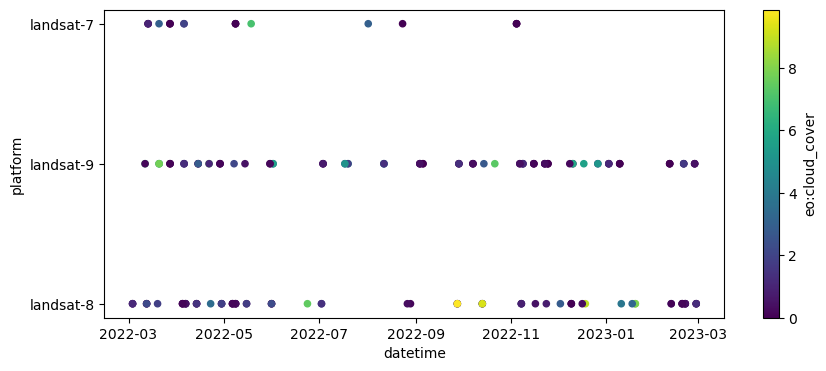

In [21]:
# Another key way to explore the data is through time:
fig,ax = plt.subplots(figsize=(10,4))
gf.plot.scatter(
    x='datetime', 
    y='platform', 
    c='eo:cloud_cover', 
    cmap='viridis', 
    ax=ax
)

<AxesSubplot:xlabel='datetime', ylabel='platform'>

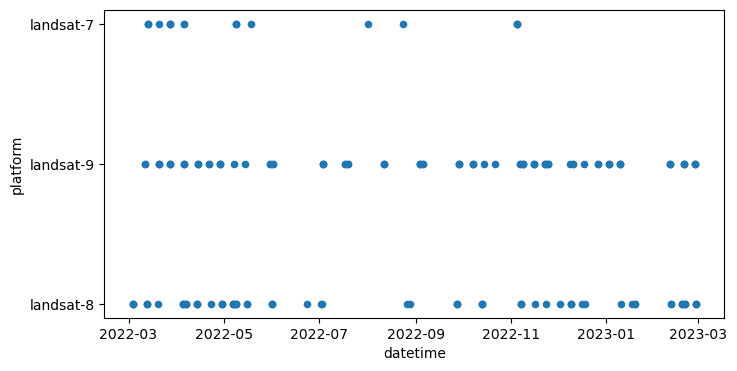

In [22]:
# Another key way to explore the data is through time: 

fig,ax = plt.subplots(figsize=(8,4))
gf.plot.scatter(x='datetime', y='platform', ax=ax)

In [25]:
%%time
ds = odc.stac.stac_load(
    items, 
    bands=["nir08", "red"], #NIR08 CALLS LANDSAT THE NIR
    bbox=bbox_of_interest,
    crs="utm",
    resolution=250, # units of output CRS (UTM)
    groupby='solar_day', # adjacent acquisition frames automatically merged. For a paticular satelite tracks, images that are merged together.
    chunks={}, # Use Dask library to divy up large dataset!
)

ds

CPU times: user 2.5 s, sys: 13.1 ms, total: 2.51 s
Wall time: 2.51 s


<xarray.Dataset>
Dimensions:      (y: 1054, x: 746, time: 72)
Coordinates:
  * y            (y) float64 6.182e+06 6.182e+06 ... 5.919e+06 5.919e+06
  * x            (x) float64 2.246e+05 2.249e+05 ... 4.106e+05 4.109e+05
    spatial_ref  int32 32721
  * time         (time) datetime64[ns] 2022-03-03T13:50:49.548072 ... 2023-02...
Data variables:
    nir08        (time, y, x) uint16 dask.array<chunksize=(1, 1054, 746), meta=np.ndarray>
    red          (time, y, x) uint16 dask.array<chunksize=(1, 1054, 746), meta=np.ndarray>

In [26]:
ds = ds.assign_coords(
    dict(stac_id=gf.stac_id, platform=gf.platform)
)

ds

<xarray.Dataset>
Dimensions:      (y: 1054, x: 746, time: 72)
Coordinates:
  * y            (y) float64 6.182e+06 6.182e+06 ... 5.919e+06 5.919e+06
  * x            (x) float64 2.246e+05 2.249e+05 ... 4.106e+05 4.109e+05
    spatial_ref  int32 32721
  * time         (time) datetime64[ns] 2022-03-03T13:50:49.548072 ... 2023-02...
    stac_id      (time) object 'LC08_L2SP_226084_20220303_02_T1' ... 'LC08_L2...
    platform     (time) object 'landsat-8' 'landsat-9' ... 'landsat-8'
Data variables:
    nir08        (time, y, x) uint16 dask.array<chunksize=(1, 1054, 746), meta=np.ndarray>
    red          (time, y, x) uint16 dask.array<chunksize=(1, 1054, 746), meta=np.ndarray>

In [27]:
# Optional: Save entire dataset locally 
ds.to_netcdf('landsat_ndvi_Arg.nc', engine='netcdf4')

#ds = xr.open_dataset('landsat_ndvi_Arg.nc')

/srv/conda/envs/notebook/lib/python3.10/site-packages/rasterio/warp.py:346: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


RasterioIOError: '/vsicurl/https://landsateuwest.blob.core.windows.net/landsat-c2/level-2/standard/oli-tirs/2022/226/085/LC08_L2SP_226085_20220319_20220329_02_T1/LC08_L2SP_226085_20220319_20220329_02_T1_SR_B5.TIF?st=2023-03-28T16%3A41%3A28Z&se=2023-04-05T16%3A41%3A28Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2023-03-29T16%3A41%3A27Z&ske=2023-04-05T16%3A41%3A27Z&sks=b&skv=2021-06-08&sig=N9Nee/o9UFuWejFIzD%2BBe3iRWWZhaZi38oTALqR01vk%3D' not recognized as a supported file format.

In [ ]:
ds.red.isel(time=slice(0,5)).plot(col='time')

In [ ]:
ds.red.where(ds.red!=0).isel(time=slice(0,5)).plot(col='time');

In [28]:
##NDVI Time Series
# Create a dataset with data that is different from zero
# Crear un conjunto de datos con los  datos que son diferentes de cero
ds = ds.where(ds!=0) 

# Calculate the NDVI | Calculamos el NDVI
ndvi = (ds.nir08 - ds.red) / (ds.nir08 + ds.red)

ndvi

<xarray.DataArray (time: 72, y: 1054, x: 746)>
dask.array<truediv, shape=(72, 1054, 746), dtype=float64, chunksize=(1, 1054, 746), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 6.182e+06 6.182e+06 ... 5.919e+06 5.919e+06
  * x            (x) float64 2.246e+05 2.249e+05 ... 4.106e+05 4.109e+05
    spatial_ref  int32 32721
  * time         (time) datetime64[ns] 2022-03-03T13:50:49.548072 ... 2023-02...
    stac_id      (time) object 'LC08_L2SP_226084_20220303_02_T1' ... 'LC08_L2...
    platform     (time) object 'landsat-8' 'landsat-9' ... 'landsat-8'

In [29]:
print('dataset size (MB):', ndvi.nbytes / 1e6)

dataset size (MB): 452.899584


In [30]:
%%time 

ndvi = ndvi.compute()

RasterioIOError: '/vsicurl/https://landsateuwest.blob.core.windows.net/landsat-c2/level-2/standard/oli-tirs/2022/226/085/LC08_L2SP_226085_20220319_20220329_02_T1/LC08_L2SP_226085_20220319_20220329_02_T1_SR_B5.TIF?st=2023-03-28T16%3A41%3A28Z&se=2023-04-05T16%3A41%3A28Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2023-03-29T16%3A41%3A27Z&ske=2023-04-05T16%3A41%3A27Z&sks=b&skv=2021-06-08&sig=N9Nee/o9UFuWejFIzD%2BBe3iRWWZhaZi38oTALqR01vk%3D' not recognized as a supported file format.

In [ ]:
ndvi.isel(time=slice(0,5)).plot(col='time', vmin=-1, vmax=1, cmap='RdYlGn');

In [ ]:
pixel = ndvi.sel(x=5.9e5, y=5.18e6, method='nearest')

pixel

In [ ]:
pixel.plot(marker='.', ls='')
plt.ylabel('NDVI');

In [ ]:
monthly_mean = pixel.groupby('time.month').mean()

monthly_mean

In [ ]:
result = monthly_mean.polyfit(deg=2, dim='month')
quadratic = xr.polyval(monthly_mean.month, result.polyfit_coefficients)

fig,ax = plt.subplots()
monthly_mean.plot(marker='o', ls='', ax=ax)
quadratic.plot(ax=ax)

In [ ]:
monthly_means = ndvi.groupby('time.month').mean() 
monthly_means.plot(col='month', col_wrap=4, vmin=-1, vmax=1, cmap='RdYlGn')

In [ ]:
df = pixel.to_dataframe(name='ndvi')
df.head(3)

In [ ]:
df.to_csv('my_timeseries.csv')